<a href="https://colab.research.google.com/github/daichisaito-cs/glasses_shape_classification/blob/main/glasses_shape_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reference

In [ ]:
# https://www.kaggle.com/datasets/zeyadkhalid/faceshape-processed/data
# https://www.kaggle.com/code/zeyadkhalid/face-shape-recognition-73-accuracy

# Setup

In [ ]:
# driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q wandb

In [ ]:
import os

ROOT_PATH = '/content/drive/Shareddrives/inSane/Workspace/EyeJapan'
DATASET_PATH = os.path.join(ROOT_PATH, 'data/glasses_shape_dataset')

In [ ]:
!ls {DATASET_PATH}

boston	leaderboard.gsheet  oval  square  wellington


# Traning

In [ ]:
# @title WandB

import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# @title data_loader.py
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor
import torch
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, processor, transform=None):
        self.root_dir = root_dir
        self.processor = processor
        self.transform = transform  # 追加の変換がある場合
        self.classes = ['oval', 'wellington', 'square', 'boston']
        self.class_to_idx = {cls.lower(): idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name.lower()])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        # CLIPの前処理
        processed = self.processor(
            images=image,
            return_tensors="pt",
            do_rescale=True
        )
        image_tensor = processed['pixel_values'].squeeze(0)

        # 追加の変換がある場合は適用
        if self.transform:
            image_tensor = self.transform(image_tensor)

        return image_tensor, self.labels[idx]

def create_data_loaders(data_dir, processor, batch_size=32, train_split=0.7, valid_split=0.15):
    """データセットを train/valid/test に分割してデータローダーを作成する関数"""
    # 全データセットを読み込む
    full_dataset = CustomImageDataset(data_dir, processor)

    # データセットのサイズを計算
    total_size = len(full_dataset)
    train_size = int(total_size * train_split)
    valid_size = int(total_size * valid_split)
    test_size = total_size - train_size - valid_size

    # データセットを分割
    train_dataset, valid_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, valid_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # データローダーの作成
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, valid_loader, test_loader

In [ ]:
# @title utils.py

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

def predict_one_shot(model, image_path, processor, device='cuda'):
    """1枚の画像に対して予測を行う関数"""
    # モデルを評価モードに
    model.eval()

    try:
        image = Image.open(image_path).convert('RGB')

        # CLIPプロセッサーで画像を処理
        processed = processor(
            images=image,
            return_tensors="pt",
            do_rescale=True
        )

        # 画像をデバイスに送る
        image_tensor = processed['pixel_values'].to(device)

        # 予測
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            # 最も確率の高いクラスとその確率を取得
            prob, predicted = torch.max(probabilities, 1)

            # クラス名を取得
            class_names = model.class_names
            predicted_class = class_names[predicted.item()]
            confidence = prob.item()

            # すべてのクラスの確率を辞書に格納
            all_probabilities = {
                class_name: round(prob.item() * 100, 2)
                for class_name, prob in zip(class_names, probabilities[0].cpu().numpy())
            }

            return {
                'predicted_class': predicted_class,
                'confidence': round(confidence * 100, 2),
                'all_probabilities': all_probabilities
            }

    except Exception as e:
        return {
            'error': str(e)
        }

def load_model(model, checkpoint_path, device='cuda'):
    """保存されたモデルをロードする関数"""
    # モデルの初期化

    # チェックポイントの読み込み
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # モデルの重みをロード
    model.load_state_dict(checkpoint['model_state_dict'])

    # デバイスに移動
    model = model.to(device)

    # 評価モードに設定
    model.eval()

    print(f"Loaded model from epoch {checkpoint['epoch']+1} with validation accuracy: {checkpoint['val_acc']:.2f}%")

    return model

# モデルのパラメータ数を表示
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# シード固定
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

In [120]:
# @title model.py

import torch.nn as nn
from transformers import CLIPModel

class ShapeClassifierBase(nn.Module):
    def __init__(self, class_names, num_classes, dropout_rate=0.2):
        super().__init__()
        self.class_names = class_names
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # 出力層
            nn.Linear(128, num_classes)
        )

        # CLIPのパラメータを凍結
        for param in self.clip.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.clip.get_image_features(x)
        outputs = self.classifier(features)
        return outputs

class GlassesClassifier(ShapeClassifierBase):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        glass_classes = ['oval', 'wellington', 'square', 'boston']
        super().__init__(glass_classes, num_classes, dropout_rate)

# class FaceClassifier(ShapeClassifierBase):
#     def __init__(self, num_classes=4):
#         face_classes = ['square', 'oblong', 'round', 'heart']
#         super().__init__(face_classes, num_classes)

# class GlassesDetector(ShapeClassifierBase):
#     def __init__(self):
#         glass_detection_classes = ['wearing_glasses', 'no_glasses']
#         super().__init__(glass_detection_classes, num_classes=2)

In [ ]:
# @title train.py

from tqdm import tqdm

def train_model(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # (images, labels) のみを受け取るように修正
    for batch_idx, (images, labels) in tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch}"
    ):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (batch_idx + 1) % 10 == 0:
            wandb.log({
                "batch": batch_idx + 1,
                "batch_loss": loss.item(),
                "batch_acc": 100. * correct / total
            })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [ ]:
# @title validate.py

def validate_model(model, valid_loader, criterion, device, epoch, split="valid"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        # (images, labels) のみを受け取るように修正
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(valid_loader)
    val_acc = 100. * correct / total

    wandb.log({
        f"{split}_loss": val_loss,
        f"{split}_accuracy": val_acc,
        "epoch": epoch
    })

    return val_loss, val_acc

In [ ]:
# @title test.py

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        # (images, labels) のみを受け取るように修正
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total

    wandb.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=all_targets,
            preds=all_predictions
        )
    })

    return accuracy, all_predictions, all_targets

In [ ]:
# @title early_stopping.py

class EarlyStopping:
    """Early Stoppingを制御するクラス"""
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience  # 改善が見られるのを待つエポック数
        self.min_delta = min_delta  # 改善とみなす最小変化量
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

=== Dataset Analysis ===

Total samples: 925

Class distribution:
oval: 167 (18.1%)
wellington: 250 (27.0%)
square: 255 (27.6%)
boston: 253 (27.4%)


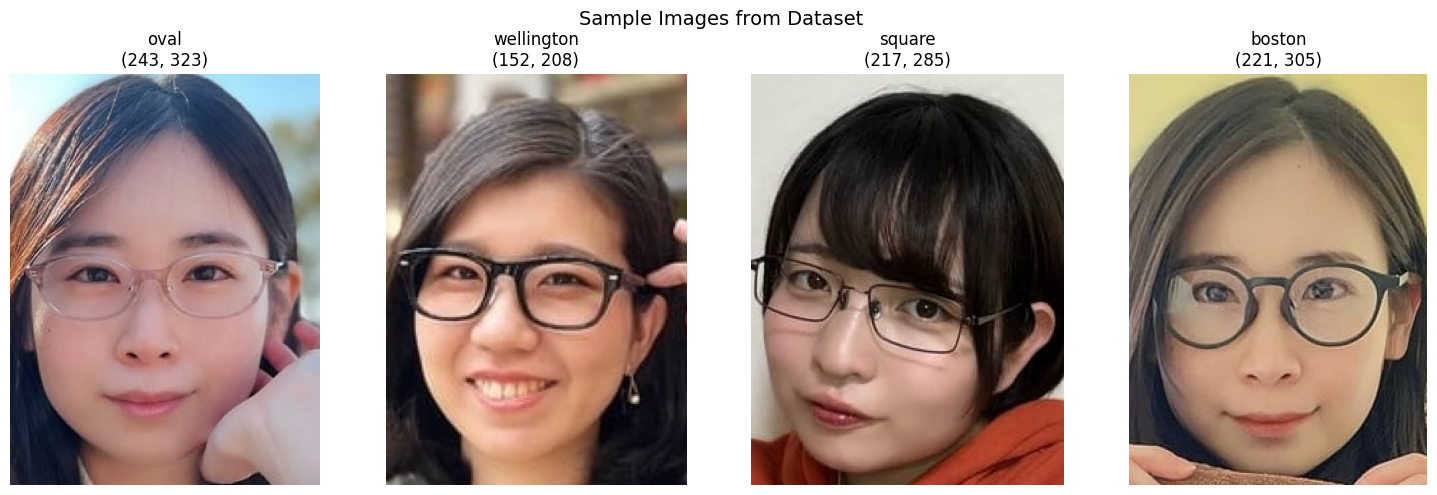

In [ ]:
# @title dataset_info.py
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def analyze_dataset(data_dir):
    """データセットの情報を分析して表示する関数"""
    classes = ['oval', 'wellington', 'square', 'boston']
    dataset_info = {}

    # データセット全体の情報を収集
    class_counts = {}
    total_samples = 0
    sample_paths = {}  # 各クラスのサンプル画像パスを保存

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} does not exist")
            class_counts[class_name] = 0
            continue

        # 画像ファイルをカウント
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[class_name] = len(images)
        total_samples += len(images)

        # ランダムなサンプル画像パスを保存
        if images:
            sample_paths[class_name] = os.path.join(class_dir, random.choice(images))

    dataset_info = {
        'total': total_samples,
        'class_counts': class_counts,
        'sample_paths': sample_paths
    }

    # 情報の表示
    print("=== Dataset Analysis ===")
    print(f"\nTotal samples: {dataset_info['total']}")
    print("\nClass distribution:")
    for class_name, count in dataset_info['class_counts'].items():
        percentage = (count / dataset_info['total'] * 100) if dataset_info['total'] > 0 else 0
        print(f"{class_name}: {count} ({percentage:.1f}%)")

    # サンプル画像の表示
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle("Sample Images from Dataset", fontsize=14)

    for i, class_name in enumerate(classes, 1):
        if class_name in dataset_info['sample_paths']:
            plt.subplot(1, 4, i)
            img_path = dataset_info['sample_paths'][class_name]
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img.size}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    return dataset_info

# データセットの分析を実行
dataset_info = analyze_dataset(DATASET_PATH)

In [114]:
# @title 転移学習
import torch
from pathlib import Path

def transfer_clip_weights(source_model_path: str, target_model: GlassesClassifier) -> GlassesClassifier:
    """
    チェックポイントファイルからCLIPの重みを転送する関数

    Args:
        source_model_path (str): チェックポイントファイルのパス
        target_model (GlassesClassifier): 転移先のモデル
    """
    # チェックポイントをロード
    checkpoint = torch.load(source_model_path)

    # モデルの重みを取得
    if 'model_state_dict' not in checkpoint:
        raise KeyError("model_state_dict not found in checkpoint file")

    state_dict = checkpoint['model_state_dict']

    # CLIPの重みを抽出
    clip_weights = {}
    for key, value in state_dict.items():
        if key.startswith('clip.'):
            clip_weights[key] = value

    if not clip_weights:
        print("Warning: No CLIP weights found in source model")
        return target_model

    # 現在のモデルの重みをアップデート
    current_state = target_model.state_dict()

    # 転送カウンター
    transfer_count = 0
    mismatch_count = 0

    # 重みを更新
    target_model.load_state_dict(current_state)

    return target_model

def verify_weight_transfer(source_model_path: str, target_model: GlassesClassifier) -> dict:
    """
    重みの転送が正しく行われたか検証する（改善版）

    Args:
        source_model_path (str): 学習済みモデルの重みファイルのパス
        target_model (GlassesClassifier): 転移後のモデル

    Returns:
        dict: 検証結果の要約
    """
    # チェックポイントから model_state_dict を取得
    checkpoint = torch.load(source_model_path)
    source_state = checkpoint['model_state_dict']
    target_state = target_model.state_dict()

    verification_results = {
        'total_clip_params': 0,
        'total_param_count': 0,
        'transferred_params': 0,
        'mismatch_params': 0,
        'param_counts_by_layer': {}
    }

    # CLIPパラメータの検証
    for key, source_param in source_state.items():
        if key.startswith('clip.'):
            verification_results['total_clip_params'] += 1
            verification_results['total_param_count'] += source_param.numel()

            # パラメータのグループ（層）を取得
            layer_group = '.'.join(key.split('.')[:3])  # 例: clip.text_model.embeddings
            if layer_group not in verification_results['param_counts_by_layer']:
                verification_results['param_counts_by_layer'][layer_group] = {
                    'total_params': 0,
                    'transferred_params': 0
                }

            verification_results['param_counts_by_layer'][layer_group]['total_params'] += source_param.numel()

            if key in target_state:
                if torch.equal(source_param, target_state[key]):
                    verification_results['transferred_params'] += 1
                    verification_results['param_counts_by_layer'][layer_group]['transferred_params'] += source_param.numel()
                else:
                    verification_results['mismatch_params'] += 1
                    print(f"Mismatch in layer: {key}")
                    print(f"Source shape: {source_param.shape}, Target shape: {target_state[key].shape}")

    # 結果の表示
    print("\n=== Weight Transfer Verification Results ===")
    print(f"Total CLIP layers: {verification_results['total_clip_params']}")
    print(f"Total parameters: {verification_results['total_param_count']:,}")

    return verification_results

In [118]:
# モデルとデータの準備
model = GlassesClassifier(num_classes=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 転移学習の実行
detector_weights_path = os.path.join(ROOT_PATH, "checkpoints/glasses_detection/2024-11-13_04-07-57.pth")
model = transfer_clip_weights(detector_weights_path, model)
results = verify_weight_transfer(detector_weights_path, model)

<ipython-input-114-10682f7a9961>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(source_model_path)
<ipython-input-114-10682f7a9961>:56: FutureWarn


=== Weight Transfer Verification Results ===
Total CLIP layers: 398
Total parameters: 151,277,313


In [106]:
def analyze_model_structure(model_path: str):
    """
    保存されているモデルの構造を分析する
    """
    checkpoint = torch.load(model_path)
    state_dict = checkpoint['model_state_dict']

    print("\n=== Model Structure Analysis ===")

    # 分類器関連のキーを抽出して表示
    classifier_keys = [k for k in state_dict.keys() if k.startswith('classifier.')]
    print("\nClassifier layers:")
    for key in classifier_keys:
        print(f"- {key}: {state_dict[key].shape}")

analyze_model_structure(os.path.join(ROOT_PATH, "checkpoints/glasses_detection/2024-11-13_05-11-10.pth"))

<ipython-input-106-4862be5c8265>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)



=== Model Structure Analysis ===

Classifier layers:
- classifier.0.weight: torch.Size([128, 512])
- classifier.0.bias: torch.Size([128])
- classifier.3.weight: torch.Size([2, 128])
- classifier.3.bias: torch.Size([2])


In [121]:
# @title main.py

from datetime import datetime
import wandb
import pytz
from torch import optim
import torch.nn as nn
import os

def run_training(model, train_loader, valid_loader, test_loader,
                num_epochs=50, patience=5, device='cuda'):
    """Early Stopping機能を追加した学習管理関数"""
    # wandbの初期化
    wandb.finish()

    # 日本時間で現在の時刻を取得
    jst = pytz.timezone('Asia/Tokyo')
    current_time = datetime.now(jst).strftime("%Y-%m-%d_%H-%M-%S")

    # チェックポイント保存用のディレクトリ作成
    base_checkpoint_dir = 'checkpoints'
    os.makedirs(base_checkpoint_dir, exist_ok=True)

    # current_time のサブディレクトリを作成
    save_dir = os.path.join(base_checkpoint_dir, current_time)
    os.makedirs(save_dir, exist_ok=True)

    wandb.init(
        project="glasses-shape-classification",
        name=f"run-{current_time}",
        config={
            "architecture": model.__class__.__name__,
            "dataset": "glasses_shapes",
            "epochs": num_epochs,
            "batch_size": train_loader.batch_size,
            "optimizer": "Adam",
            "learning_rate": 0.001,
            "early_stopping_patience": patience
        }
    )

    # モデルをwandbで追跡
    wandb.watch(model, log="all")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    best_val_acc = 0
    best_model_path = None

    for epoch in range(num_epochs):
        # 学習
        train_loss, train_acc = train_model(
            model, train_loader, optimizer, criterion, device, epoch
        )

        # 検証
        val_loss, val_acc = validate_model(
            model, valid_loader, criterion, device, epoch
        )

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # モデルの保存
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # 以前のベストモデルを削除
            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)

            # 新しいベストモデルを保存
            best_model_path = os.path.join(save_dir, f'best_model_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, best_model_path)

            # wandbにモデルをアップロード
            artifact = wandb.Artifact(
                name=f'best-model-epoch-{epoch+1}',
                type='model',
                description=f'Best model checkpoint from epoch {epoch+1}'
            )
            artifact.add_file(best_model_path)
            wandb.log_artifact(artifact)

            print(f'Model saved to {best_model_path} with validation accuracy: {val_acc:.2f}%')

        # Early Stoppingの判定
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    # 最良のモデルを読み込む
    if best_model_path:
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f'Loaded best model from epoch {checkpoint["epoch"]+1} '
              f'with validation accuracy: {checkpoint["val_acc"]:.2f}%')

    # テストデータで評価
    test_acc, predictions, targets = test_model(model, test_loader, device)
    print(f'\nFinal Test Accuracy: {test_acc:.2f}%')

    return model, best_model_path, save_dir  # save_dirも返すように変更

# モデルとデータの準備
model = GlassesClassifier(num_classes=4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 転移学習の実行
detector_weights_path = os.path.join(ROOT_PATH, "checkpoints/glasses_detection/2024-11-13_04-07-57.pth")
model = transfer_clip_weights(detector_weights_path, model)
results = verify_weight_transfer(detector_weights_path, model)

# プロセッサーの取得
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# データローダーの作成
train_loader, valid_loader, test_loader = create_data_loaders(
    DATASET_PATH,
    processor=processor,
    batch_size=32
)

# 学習の実行（Early Stoppingのパラメータを指定可能）
trained_model, best_model_path, checkpoint_dir = run_training(
    model,
    train_loader,
    valid_loader,
    test_loader,
    num_epochs=200,
    patience=7,
    device=device
)

print(f"Checkpoints saved in: {checkpoint_dir}")

<ipython-input-114-10682f7a9961>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(source_model_path)
<ipython-input-114-10682f7a9961>:56: FutureWarn


=== Weight Transfer Verification Results ===
Total CLIP layers: 398
Total parameters: 151,277,313


Epoch 0: 100%|██████████| 21/21 [00:10<00:00,  1.96it/s]



Epoch 1/200:
Train Loss: 1.3401, Train Acc: 35.86%
Val Loss: 1.2383, Val Acc: 39.86%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_1.pth with validation accuracy: 39.86%


Epoch 1: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]



Epoch 2/200:
Train Loss: 1.0842, Train Acc: 56.11%
Val Loss: 1.0817, Val Acc: 46.38%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_2.pth with validation accuracy: 46.38%


Epoch 2: 100%|██████████| 21/21 [00:13<00:00,  1.56it/s]



Epoch 3/200:
Train Loss: 0.9598, Train Acc: 60.59%
Val Loss: 1.0337, Val Acc: 51.45%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_3.pth with validation accuracy: 51.45%


Epoch 3: 100%|██████████| 21/21 [00:13<00:00,  1.56it/s]



Epoch 4/200:
Train Loss: 0.8591, Train Acc: 67.85%
Val Loss: 0.9830, Val Acc: 52.17%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_4.pth with validation accuracy: 52.17%


Epoch 4: 100%|██████████| 21/21 [00:13<00:00,  1.52it/s]



Epoch 5/200:
Train Loss: 0.8123, Train Acc: 66.92%
Val Loss: 0.9497, Val Acc: 57.25%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_5.pth with validation accuracy: 57.25%


Epoch 5: 100%|██████████| 21/21 [00:12<00:00,  1.65it/s]



Epoch 6/200:
Train Loss: 0.7548, Train Acc: 71.25%
Val Loss: 0.9222, Val Acc: 57.97%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_6.pth with validation accuracy: 57.97%


Epoch 6: 100%|██████████| 21/21 [00:13<00:00,  1.58it/s]



Epoch 7/200:
Train Loss: 0.7198, Train Acc: 73.11%
Val Loss: 0.8764, Val Acc: 60.87%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_7.pth with validation accuracy: 60.87%


Epoch 7: 100%|██████████| 21/21 [00:13<00:00,  1.51it/s]



Epoch 8/200:
Train Loss: 0.6651, Train Acc: 74.65%
Val Loss: 0.8818, Val Acc: 59.42%
EarlyStopping counter: 1 out of 7


Epoch 8: 100%|██████████| 21/21 [00:10<00:00,  2.00it/s]



Epoch 9/200:
Train Loss: 0.6323, Train Acc: 77.59%
Val Loss: 0.8723, Val Acc: 63.04%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_9.pth with validation accuracy: 63.04%


Epoch 9: 100%|██████████| 21/21 [00:13<00:00,  1.61it/s]



Epoch 10/200:
Train Loss: 0.5606, Train Acc: 80.06%
Val Loss: 0.8968, Val Acc: 63.04%
EarlyStopping counter: 1 out of 7


Epoch 10: 100%|██████████| 21/21 [00:10<00:00,  2.01it/s]



Epoch 11/200:
Train Loss: 0.5621, Train Acc: 80.06%
Val Loss: 0.8543, Val Acc: 64.49%
Model saved to checkpoints/2024-11-13_05-56-09/best_model_epoch_11.pth with validation accuracy: 64.49%


Epoch 11: 100%|██████████| 21/21 [00:13<00:00,  1.50it/s]



Epoch 12/200:
Train Loss: 0.5456, Train Acc: 80.06%
Val Loss: 0.8774, Val Acc: 60.87%
EarlyStopping counter: 1 out of 7


Epoch 12: 100%|██████████| 21/21 [00:10<00:00,  2.01it/s]



Epoch 13/200:
Train Loss: 0.5007, Train Acc: 83.00%
Val Loss: 0.8321, Val Acc: 63.04%


Epoch 13: 100%|██████████| 21/21 [00:10<00:00,  1.98it/s]



Epoch 14/200:
Train Loss: 0.4789, Train Acc: 85.78%
Val Loss: 0.8757, Val Acc: 61.59%
EarlyStopping counter: 1 out of 7


Epoch 14: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]



Epoch 15/200:
Train Loss: 0.4473, Train Acc: 84.23%
Val Loss: 0.8753, Val Acc: 60.14%
EarlyStopping counter: 2 out of 7


Epoch 15: 100%|██████████| 21/21 [00:10<00:00,  2.05it/s]



Epoch 16/200:
Train Loss: 0.4427, Train Acc: 87.48%
Val Loss: 0.8505, Val Acc: 60.14%
EarlyStopping counter: 3 out of 7


Epoch 16: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]



Epoch 17/200:
Train Loss: 0.3994, Train Acc: 87.33%
Val Loss: 0.8540, Val Acc: 62.32%
EarlyStopping counter: 4 out of 7


Epoch 17: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]



Epoch 18/200:
Train Loss: 0.3966, Train Acc: 87.64%
Val Loss: 0.8536, Val Acc: 64.49%
EarlyStopping counter: 5 out of 7


Epoch 18: 100%|██████████| 21/21 [00:10<00:00,  2.03it/s]



Epoch 19/200:
Train Loss: 0.3612, Train Acc: 87.33%
Val Loss: 0.8564, Val Acc: 60.14%
EarlyStopping counter: 6 out of 7


Epoch 19: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]



Epoch 20/200:
Train Loss: 0.3400, Train Acc: 90.11%
Val Loss: 0.8452, Val Acc: 62.32%
EarlyStopping counter: 7 out of 7
Early stopping triggered at epoch 20


<ipython-input-121-0c1393ddae6f>:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


Loaded best model from epoch 11 with validation accuracy: 64.49%

Final Test Accuracy: 53.57%
Checkpoints saved in: checkpoints/2024-11-13_05-56-09


In [113]:
wandb.finish()

In [75]:
print(best_model_path)

checkpoints/2024-11-13_04-09-24/best_model_epoch_46.pth


In [102]:
# @title predict_one_shot.py

from transformers import CLIPProcessor

# モデルとプロセッサーの準備
model = GlassesClassifier(num_classes=4)
# モデルのロード
model = load_model(model, best_model_path, device=device)

# プロセッサーの準備
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 画像の予測
image_path = os.path.join(ROOT_PATH, 'data/test_images/square.jpg')
result = predict_one_shot(model, image_path, processor, device)

if 'error' in result:
    print(f"Error: {result['error']}")
else:
    print(f"Predicted class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']}%")
    print("\nAll class probabilities:")
    for class_name, prob in result['all_probabilities'].items():
        print(f"{class_name}: {prob}%")

<ipython-input-61-ed637048dd04>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from epoch 19 with validation accuracy: 70.29%
Predicted class: wellington
Confidence: 73.91%

All class probabilities:
oval: 0.31%
wellington: 73.91%
square: 25.62%
boston: 0.17%
